<a href="https://colab.research.google.com/github/tonyamf/DeepGrads/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

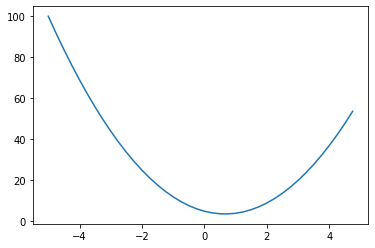

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 3.0
(f(x+ h) - f(x))/h

14.000003002223593

In [6]:
#let get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b= -3.0
c = 10.0  

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1) / h )

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [49]:
#McroGrad build


class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda:None#this is going to be that function that going to do that chain rule, at the moment it  not doing anything
        # internal variables used for autograd graph construction
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __radd__(self, other):
        return self +  other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad +=  1.0 * out.grad
        out._backward = _backward

        
        return out

    def __rmul__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
          self.grad += other.data * out.grad
          other.grad +=  self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only support int/float for now" 
      out = Value(self.data**other, (self,), f'**{other}')
    
      def _backward():
        self.grad += other *( self.data ** (other - 1)) * out.grad
      out._backward = _backward
      
      return out

    def __truediv__(self, other):
      return self * other**-1

    def __neg__(self):
      return self * -1

    def __rsub__(self, other):
      return (-self) + other

    def __sub__(self, other):
      return self + (-other)
    
    def tanh(self):
      n = self.data
      t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
      out=  Value(t, (self,), 'tanh')

      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward

      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad = out.data * out.grad
      out._backward = _backward

      
      return out


    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
          node._backward()

In [50]:
 from graphviz import Digraph

 def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):

    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [51]:
a =Value(2.0)
a-1

Value(data=1.0)

In [52]:
#
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

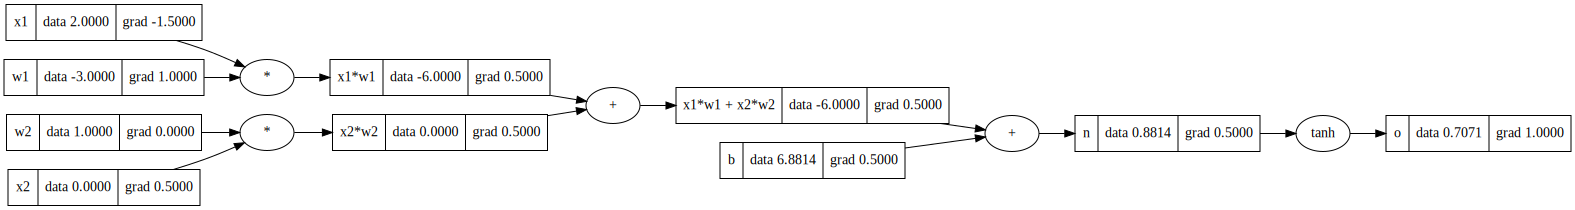

In [53]:
draw_dot(o)

In [54]:
#EXample with pytorch
import torch
x1 = torch.Tensor([2.0]).double()                               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                               ; x2.requires_grad = True
w1 = torch.Tensor([2.0]).double()                               ; w1.requires_grad = True
w2 = torch.Tensor([2.0]).double()                               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()                 ; b.requires_grad = True
n = x1*w1 +x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.9999999992927237
---------------
x2 2.8291053933969226e-09
w2 0.0
x1 2.8291053933969226e-09
w1 2.8291053933969226e-09


In [55]:
import random

In [66]:
class Neuron:
   
   def __init__(self, nin) -> None:
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1, 1))

   def __call__(self, x):
     act = sum((wi*xi for wi, xi in zip(self.w, x)), b)
     out = act.tanh()
     return out

   def parameters(self):
     return self.w + [self.b]

In [68]:
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [69]:
class MLP:

    def __init__(self, nin, nouts):
      sz = [nin ] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

    def __call__(self, x):
      for layer in self.layers:
         x = layer(x)
      return x
    
    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [70]:
x = [ 2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9999869855428573)

In [90]:
xs = [ [2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0],[1.0, 1.0, -1.0],]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

In [91]:
ypred

[Value(data=0.9999869829410563),
 Value(data=0.9999869829410802),
 Value(data=0.9999869829410855),
 Value(data=0.9999869829410838)]

In [98]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss


Value(data=7.999895864206439)

In [95]:
loss.backward()

In [96]:
n.layers[0].neurons[0].w[0].grad

1.0615983457528952e-13

In [97]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
w1._backward()

In [ ]:
w2._backward()

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
n.grad = 0.5

In [ ]:
o.grad = 1.0

In [ ]:
n.grad = 1 - o**2